In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.linalg import svd

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SckillFactory/ВУЗ/диплом/data/total_cpi_MinMaxScaler.csv')
df['ds'] = pd.to_datetime(df['ds'])

df = df.reset_index().rename(columns={'index': 'unique_id', 'ws': 'y'})
df['unique_id'] = df['unique_id'].apply(lambda x: '0')

end_train_start_test = int(len(df) * .85)
train_index, test_index = range(end_train_start_test), range(end_train_start_test, len(df))
Y_train_df, Y_test_df = df.iloc[train_index], df.iloc[test_index].reset_index(drop=True)

## STL + Holt + SeasonNaive

### **units** (exp_weights, _Holt_fc, _SeasonNaive_fc)

In [ ]:
def exp_weights(n, alpha=0.5):
  weights = np.array([alpha ** (n - i) for i in range(1, n + 1)])
  weights /= weights.sum()
  return weights

exp_weights(2)

array([0.33333333, 0.66666667])

In [ ]:
def exp_weights(n, alpha=0.5):
  weights = np.array([alpha ** (n - i) for i in range(1, n + 1)])
  weights /= weights.sum()
  return weights

def _Holt_forecast(trend, h):
  '''
  Возвращает тренд + прогноз
  '''
  model = ExponentialSmoothing(
      trend,
      trend='add',  # 'add' для аддитивного тренда, 'mul' для мультипликативного
      seasonal=None,  # без сезонности
      initialization_method='estimated'
  ).fit()

  # Прогнозируем на период тестовой выборки
  forecast = model.forecast(h)
  return np.concat([trend, forecast])

def _SeasonNaive_forecast(season, seasonal_period, h, method='mean', alpha=.5):
  '''
  Делает наивный сезонный пргноз

  method: ['mean', 'exp']
    mean - берется среднеепо всем периодам
    exp - значения периодов умножаются на экспоненциальные веса
    naive - берется последний период
  '''
  season_fc = season.copy()
  for _ in range(h):
    fc = np.array([season_fc[i] for i in range(len(season_fc) - seasonal_period, -1, -seasonal_period)])

    if method == 'mean':
      fc = fc.mean()
    elif method == 'exp':
      fc = np.flip(exp_weights(len(fc), alpha)) * fc
      fc = fc.sum()
    elif method == 'naive':
      fc = fc[0]
    else:
      raise f'method {method} is unknow'

    season_fc = np.concat([season_fc, np.array([fc])])

  return season_fc

### show

In [ ]:
def show_ts(on_y, on_x, labels=['Исходный ряд', 'Модель', 'Прогноз'], title=None, color=['b', 'g', 'y']):
  plt.figure(figsize=(12, 5))
  for i, label in enumerate(labels):
    plt.plot(on_x[i], on_y[i], c=color[i], label=label)
  plt.legend()
  if title is not None:
    plt.title(title)
  plt.show()

### **models** (stl_seasosnal_naive_fc)

In [ ]:
def stl_seasonal_naive_forecast(series, seasonal_period, h, method_SN='mean', alphs_SN=.5, show=False, show_components=False):
  """
  Прогнозирование методом STL + SeasonNaive

  Параметры:
  series - временной ряд (pd.Series)
  seasonal_period - длина сезонного периода
  h - горизонт прогнозирования

  Возвращает:
  forecast - прогноз на h шагов вперед
  """
  # Выполняем STL декомпозицию
  stl = STL(series, period=seasonal_period, robust=True)
  result = stl.fit()

  # Получаем компоненты
  trend = _Holt_forecast(result.trend, h)
  seasonal = _SeasonNaive_forecast(result.seasonal, seasonal_period, h, method=method_SN)

  forecast = trend + seasonal


  if show:
    show_ts(
      on_x=[df.ds, Y_train_df.ds, Y_test_df.ds],
      on_y=[df.y, model[train_index], forecast[test_index]],
      title='STL + Holt + SNaive'
  )
  if show_components:
    result.plot()
    plt.suptitle('STL-декомпозиция с разложением на компоненты')
    plt.tight_layout()
    plt.show()

  return (forecast[:len(series)], forecast[len(series):], series - forecast[:len(series)])

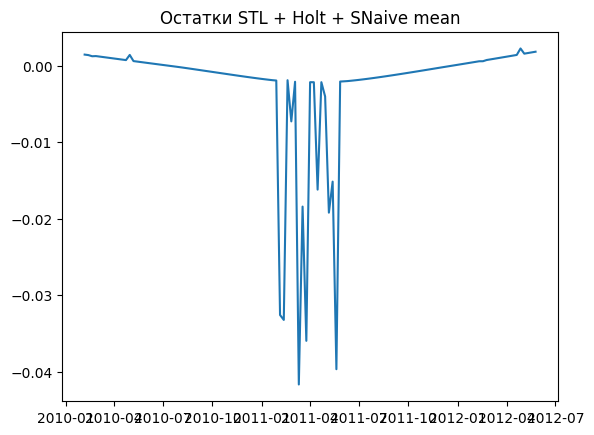

In [ ]:
plt.plot(Y_train_df.ds, resid_mean)
plt.title('Остатки STL + Holt + SNaive mean')
plt.show()

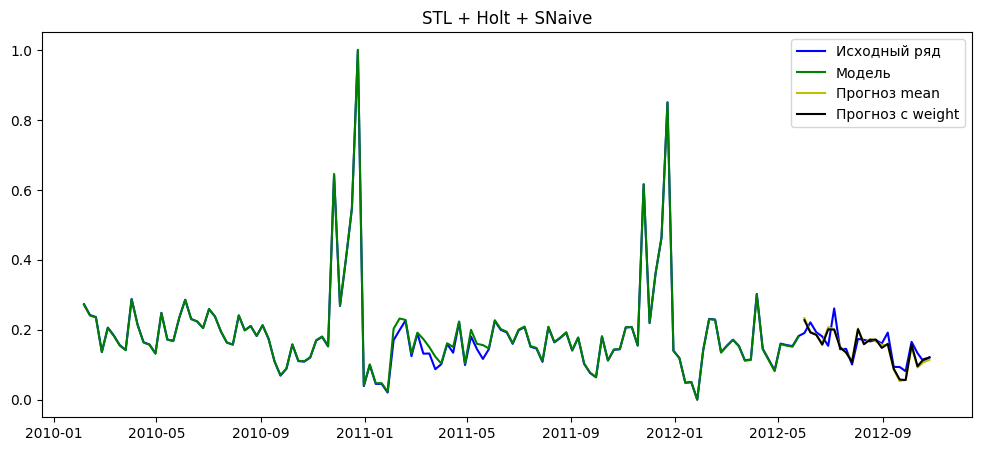

In [ ]:
model, forecast_mean, resid_mean = stl_seasonal_naive_forecast(Y_train_df.y.values, 52, len(Y_test_df))
model, forecast_exp, resid_exp = stl_seasonal_naive_forecast(Y_train_df.y.values, 52, len(Y_test_df), 'exp', 0.02)

show_ts(
    on_x=[df.ds, Y_train_df.ds, Y_test_df.ds, Y_test_df.ds],
    on_y=[df.y, model, forecast_mean, forecast_exp],
    labels=['Исходный ряд', 'Модель', 'Прогноз mean', 'Прогноз с weight'],
    color=['b', 'g', 'y', 'black'],
    title='STL + Holt + SNaive'
)

In [ ]:
df_forecast = pd.read_csv('/content/drive/MyDrive/SckillFactory/ВУЗ/диплом/data/output/forecast_neural.csv')
df_forecast['STL_H_SNaive_mean'] = forecast_mean
df_forecast['STL_H_SNaive_exp'] = forecast_exp
df_forecast.to_csv('/content/drive/MyDrive/SckillFactory/ВУЗ/диплом/data/output/forecast_neural.csv')

In [ ]:
print('Метрики модели с весами')
print(f'MAE: {mean_absolute_error(Y_test_df.y, forecast_exp)}')
print(f'MSE: {mean_squared_error(Y_test_df.y, forecast_exp)}')
print(f'MAPE: {mean_absolute_percentage_error(Y_test_df.y, forecast_exp)}')

Метрики модели с весами
MAE: 0.01986095421543007
MSE: 0.0006598466688839822
MAPE: 0.1302670733200074


In [ ]:
print('Метрики модели без весов')
print(f'MAE: {mean_absolute_error(Y_test_df.y, forecast_mean)}')
print(f'MSE: {mean_squared_error(Y_test_df.y, forecast_mean)}')
print(f'MAPE: {mean_absolute_percentage_error(Y_test_df.y, forecast_mean)}')

Метрики модели без весов
MAE: 0.021315151687820586
MSE: 0.0007431245543163528
MAPE: 0.141503911986381


## STL + Holt + SARIMA

In [ ]:
def _sarima_forecast(season, seasonal_period, h):
  model = SARIMAX(season, order=(5, 0, 1), seasonal_order=(1, 0, 0, seasonal_period))
  result = model.fit()
  forecast = result.forecast(steps=h)
  return np.concat([result.fittedvalues, forecast])

def stl_sarima_forecast(series, seasonal_period, h, show=False, show_components=False):
  """
  Прогнозирование методом STL + SeasonNaive

  Параметры:
  series - временной ряд (pd.Series)
  seasonal_period - длина сезонного периода
  h - горизонт прогнозирования

  Возвращает:
  forecast - прогноз на h шагов вперед
  """
  # Выполняем STL декомпозицию
  stl = STL(series, period=seasonal_period, robust=True)
  result = stl.fit()

  # Получаем компоненты
  trend = _Holt_forecast(result.trend, h)
  seasonal = _sarima_forecast(result.seasonal, seasonal_period, h)

  forecast = trend + seasonal


  if show:
    show_ts(
      on_x=[df.ds, Y_train_df.ds, Y_test_df.ds],
      on_y=[df.y, model[train_index], forecast[test_index]],
      title='STL + Holt + SARMA'
  )
  if show_components:
    result.plot()
    plt.suptitle('STL-декомпозиция с разложением на компоненты')
    plt.tight_layout()
    plt.show()

  return (forecast[:len(series)], forecast[len(series):], series - forecast[:len(series)])

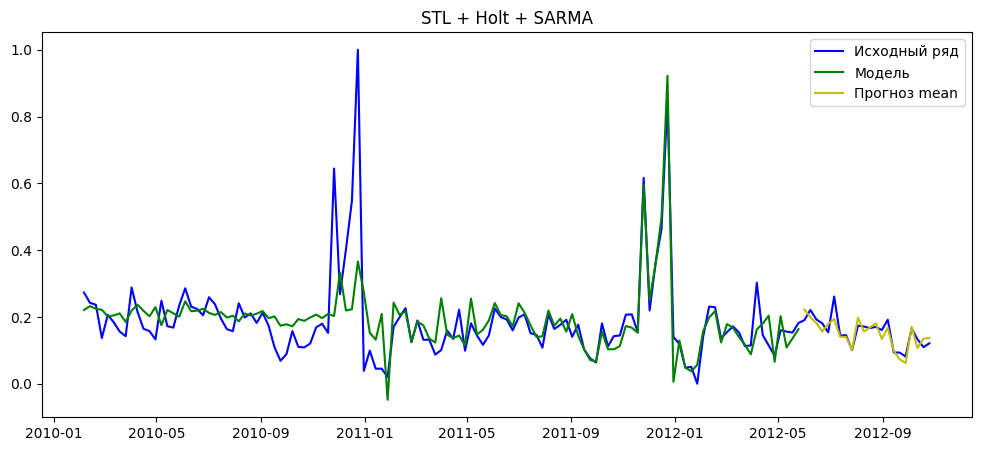

In [ ]:
model, forecast, resid = stl_sarima_forecast(Y_train_df.y.values, 52, len(Y_test_df))

show_ts(
    on_x=[df.ds, Y_train_df.ds, Y_test_df.ds],
    on_y=[df.y, model, forecast],
    labels=['Исходный ряд', 'Модель', 'Прогноз mean'],
    title='STL + Holt + SARMA'
)

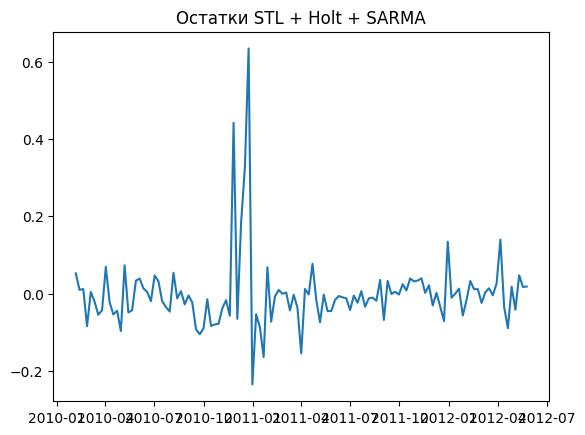

In [ ]:
plt.plot(Y_train_df.ds, resid)
plt.title('Остатки STL + Holt + SARMA')
plt.show()

In [ ]:
df_forecast = pd.read_csv('/content/drive/MyDrive/SckillFactory/ВУЗ/диплом/data/output/forecast_neural.csv')
df_forecast['STL_H_SARIMA'] = forecast
df_forecast.to_csv('/content/drive/MyDrive/SckillFactory/ВУЗ/диплом/data/output/forecast_neural.csv')

In [ ]:
print(f'MAE: {mean_absolute_error(Y_test_df.y, forecast)}')
print(f'MSE: {mean_squared_error(Y_test_df.y, forecast)}')
print(f'MAPE: {mean_absolute_percentage_error(Y_test_df.y, forecast)}')

MAE: 0.018551707486215745
MSE: 0.00041495305628569943
MAPE: 0.13905999993563364


## library

In [ ]:
from numpy.typing import NDArray
import math as mt
import itertools

### Show

In [ ]:
class BaseError(Exception):
  def __init__(self, message: str):
    super().__init__(message)

  @classmethod
  def shapeError(*args):
    for i in range(2, len(args) - 1):
      assert args[i].shape == args[i + 1].shape, BaseError(f'x and y must have same first dimension, {args[i].shape} and {args[i + 1].shape}')


class SubplotError(Exception):
  def __init__(self, message: str):
    super().__init__(message)

  @classmethod
  def all_arg_one_type(*args):
    types = set([type(arg) for arg in args[1:]])
    assert len(types) == 1, SubplotError(f'Arguments don`t have one type')

  @classmethod
  def shapeError(*args):
    BaseError.shapeError(*args)


class Show():
    def __init__(self, base_figsize=(5, 2)) -> None:
        self.fig, self.axes = None, None
        self.shape, self.pos = None, [0, 0]
        self.base_figsize = base_figsize  # базовый размер для одного подграфика

    def create_subplot(self, nrows: int, ncols: int) -> None:
        self.shape = [nrows, ncols]
        # Автоматический расчет размера фигуры на основе количества подграфиков
        fig_width = self.base_figsize[0] * ncols
        fig_height = self.base_figsize[1] * nrows
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height))

    def add_subplot(self, xvalue: NDArray, yvalue: NDArray, title, **kwargs):
        if self.shape[0] == 1 and self.shape[1] == 1:
            self.axes.plot(xvalue, yvalue, **kwargs)
        elif self.shape[0] == 1 or self.shape[1] == 1:
            self.axes[self.pos[0] if self.shape[0] > 1 else self.pos[1]].plot(xvalue, yvalue, **kwargs)
        else:
            self.axes[self.pos[0], self.pos[1]].plot(xvalue, yvalue, **kwargs)
            self.axes[self.pos[0], self.pos[1]].set_title(title)

        if self.pos[1] + 1 < self.shape[1]:
            self.pos[1] += 1
        else:
            self.pos[0] += 1
            self.pos[1] = 0

    def subplot(self, xvalues: NDArray, yvalues: NDArray, nrows: int, ncols: int):
        SubplotError.shapeError(xvalues, yvalues)
        self.create_subplot(nrows, ncols)

        for i in range(xvalues.shape[0]):
            self.add_subplot(xvalues[i], yvalues[i], title=f'k={i}')

        plt.subplots_adjust(wspace=0.3, hspace=0.4)
        plt.show()

    def subplot_x(self, yvalues: NDArray, ncols: int) -> None:
        xvalues = [np.arange(yvalues.shape[1])] * yvalues.shape[0]
        nrows = mt.ceil(yvalues.shape[0] / ncols)
        self.subplot(np.array(xvalues), yvalues, nrows, ncols)

    def one_plot(self, y: NDArray, labels: NDArray, x: NDArray = None, title: str = None, show_labels=True) -> None:
        if x is None:
          x = np.array([np.arange(y.shape[1])] * y.shape[0])

        SubplotError.shapeError(x, y)

        for i, yv in enumerate(y):
          plt.plot(x[i], yv, label=labels[i] if show_labels else None)

        if title:
          plt.title(title)
        plt.legend()
        plt.show()

### GenerateData Analytics

In [ ]:
class GenerateDataError(Exception):
  def __init__(self, message: str):
    super().__init__(message)

  @classmethod
  def other_ts(*args):
    for i in range(1, len(args[1:]) - 1):
      assert (args[i].ts != args[i + 1].ts).sum(), GenerateDataError('Diferent time series')

  @classmethod
  def add_error(cls):
    raise GenerateDataError('Error add')

  @classmethod
  def init_param(cls, ts, change, data):
    assert data is not None or (ts is not None and change is not None), GenerateDataError('data or (ts and change) can be not None')


class GenerateData():
  def __init__(self, ts: NDArray = None, change: NDArray = None,  data=None, method: str = 'additive') -> None:
    GenerateDataError.init_param(ts, change, data)
    self.data = data
    if change is not None and ts is not None:
       if method == 'additive':
         self.data = self.additive_date(ts, change)

  def __add__(self, other):
    if isinstance(other, GenerateData):
      GenerateDataError.other_ts(self, other)
      data = np.vstack((self.data, other.data))
      return GenerateData(data=data)
    else:
      GenerateDataError.add_error()

  def additive_date(self, ts: NDArray, change: NDArray):
    ready = [ts + ch for ch in change]
    return np.array(ready)


class Analytics():
  def __init__(self, data: GenerateData, title: NDArray = None) -> None:
     self.title = title
     self.data = data

  def correlogram_compare(self, lags=52, alpha=.05, figsize=(12, 6)) -> None:
    nrows = self.data.shape[0]
    figsize = (figsize[0], figsize[1] * nrows / 3)
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=figsize)
    axes = axes.ravel()
    i_axes = 0

    for i in range(self.data.shape[0]):
      plot_acf(self.data[i],
               lags=lags,
               ax=axes[i_axes],
               alpha=alpha,
               title=f'ACF {self.title[i] if self.title is not None else ""}',
               zero=False)
      plot_pacf(self.data[i],
                lags=lags,
                alpha=alpha,
                ax=axes[i_axes + 1],
                title=f'PACF {self.title[i] if self.title is not None else ""}',
                zero=False)
      i_axes += 2

    # Настройка общего заголовка
    plt.suptitle(f'Correlograms for Time Series Analysis (α={alpha})', y=1.02)
    plt.tight_layout()
    plt.show()

  def correlogram_compare_one(self, lags=52, alpha=.05, figsize=(12, 6)) -> None:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figsize)

    for i in range(self.data.shape[0]):
      plot_acf(self.data[i],
               lags=lags,
               ax=ax1,
               alpha=alpha,
               title=f'ACF',
               zero=False)
      plot_pacf(self.data[i],
                lags=lags,
                alpha=alpha,
                ax=ax2,
                title=f'PACF',
                zero=False)

    plt.suptitle(f'Correlograms for Time Series Analysis (α={alpha})', y=1.02)
    plt.tight_layout()
    plt.show()

  def plot_ts(self) -> None:
    show = Show()
    show.subplot_x(self.data, 2)

### Split STLHSNaiveCompare

In [ ]:
class SplitTrainTestError(Exception):
  def __init(self, message):
    super().__init__(message)

  def half(half):
    assert half >= 0 and half <= 1, SplitTrainTestError(f'The half can be belongs to the interval [0, 1]')



class SplitTrainTest():
  def __init__(self, data: GenerateData, half: float | int):
    SplitTrainTestError.half(half)

    self.half = half
    self.data_original = data
    self.train_index, self.test_index = self.__get_split_index(self.data_original.shape[1])
    self.data_split = None

  def __get_split_index(self, len):
    end_train_start_test = int(len * self.half)
    return np.arange(0, end_train_start_test), np.arange(end_train_start_test, len)

  def split(self):
    new_data = [[dt[self.train_index], dt[self.test_index]] for dt in self.data_original]
    self.data_split = new_data
    return self.data_split

  def split_use_signs(self, df_sings):
    self.split()
    x_train, x_test = df_sings.iloc[self.train_index], df_sings.iloc[self.test_index]
    return (x_train, x_test, self.data_split)


class ModelCompare():
  def __init__(self, gd: GenerateData, name: NDArray, df_path: str, df_path_long_forecast: str, columns, step_lf: int):
    self.params = []

    self.split = SplitTrainTest(gd.data, .85)
    self.data = self.split.data_split
    self.name = name
    self.df_path = df_path
    self.df_path_long_forecast = df_path_long_forecast
    self.df = pd.DataFrame(columns=columns)

    if self.df_path_long_forecast is not None:
      self.df_long_forecast = pd.DataFrame(columns=[f'{cl}' for cl in range(step_lf, self.split.test_index.size, step_lf)])


class STLHSNaiveCompare(ModelCompare):
  def __init__(self, gd: GenerateData, name: NDArray, df_path: str, df_path_long_forecast: str = None, step_lf=3) -> None:
    columns=['name', 'mae', 'mse']
    super().__init__(gd, name, df_path, df_path_long_forecast, columns, step_lf)
    self.data = self.split.split()

  def build_STLHSNaive(self, i_data: int):
    train_ = self.data[i_data][0]
    test_ = self.data[i_data][1]

    h = len(self.split.test_index)
    model, forecast_mean_, resid = stl_seasonal_naive_forecast(train_, 52, h)

    mae = mean_absolute_error(test_, forecast_mean_)
    mse = mean_squared_error(test_, forecast_mean_)

    self.df.loc[self.df.shape[0]] = [self.name[i_data], mae, mse]
    self.df.to_csv(self.df_path, index=False)

    if self.df_path_long_forecast is not None:
      warnings.warn("Not provided long forecast")

  def compare(self) -> None:

    print(f'All combinations {len(self.data)}')
    i_combination = 1

    for i_data in range(len(self.data)):
      print(f'cimbination {i_combination}')
      i_combination += 1
      self.build_STLHSNaive(i_data)

### STLHSARIMACompare

In [ ]:
class STLHSARIMACompare(ModelCompare):
  def __init__(self, gd: GenerateData, name: NDArray, df_path: str, df_path_long_forecast: str = None, step_lf=3) -> None:
    columns=['name', 'mae', 'mse']
    super().__init__(gd, name, df_path, df_path_long_forecast, columns, step_lf)
    self.data = self.split.split()

  def build_STLHSARIMA(self, i_data: int):
    train = self.data[i_data][0]
    test = self.data[i_data][1]

    h = len(self.split.test_index)

    model, forecast, resid = stl_sarima_forecast(train, 52, h)

    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)

    self.df.loc[self.df.shape[0]] = [self.name[i_data], mae, mse]
    self.df.to_csv(self.df_path, index=False)

    if self.df_path_long_forecast is not None:
      warnings.warn("Not provided long forecast")

  def compare(self) -> None:
    print(f'All combinations {len(self.data)}')
    i_combination = 1

    for i_data in range(len(self.data)):
      print(f'cimbination {i_combination}')
      i_combination += 1
      self.build_STLHSARIMA(i_data)

### BestParams

In [ ]:

class BestParams():
  def __init__(self):
    self.df = pd.DataFrame()
    self.df_long_forecast = pd.DataFrame()
    self.best_params = []

  def load(self, path_df, path_df_lf=None):
    self.df = pd.read_csv(path_df)
    if path_df_lf:
      self.df_long_forecast = pd.read_csv(path_df_lf)

  def get_best_params(self, columns_params, sort_by):
    best_params = []
    for name in self.df['name'].unique():
      dff = self.df[self.df['name'] == name]
      dffs = dff.sort_values(by=sort_by, ascending=[True, True]).iloc[0]  # сортируем и берем первую строку
      params = {clp: dffs[clp] for clp in columns_params}
      best_params.append(params)
    return best_params

  def search_best_params(self, columns_params, sort_by=['aicc', 'bic']):
    best_params = self.get_best_params(columns_params, sort_by=sort_by)
    for bp in best_params:
      self.best_params.append(list(bp.values()))
    return self.best_params

  def print(self):
    for bp in self.best_params:
      for i, b in enumerate(bp):
        if i == 0:
          print('[', end='')
        print(b, end='')
        if i == len(bp) - 1:
          print(']')
        else:
          print(', ', end='')

  def __args_plot(self, bp, type_ts, inf_cr, name):
    information_cr, title, labels, x = [[] for _ in range(len(inf_cr))], [], [], []
    for b_dict in bp:
      if type_ts in b_dict[name]:
        for i, cr in enumerate(inf_cr):
          information_cr[i].append(b_dict[cr])
        fb_dict_key = [
            key
            for key in b_dict.keys()
            if key not in [name] + inf_cr
        ]
        title.append((b_dict[k] for k in fb_dict_key))
        x.append(float(b_dict[name].split(type_ts + '=')[-1]))

    for title_name in title:
      string = ''
      for tn in title_name:
        string += str(tn) + ' '
      labels.append(string)
    return information_cr, labels, x

  def plot(self, columns_params, type_ts=['k', 'alpha', 'freq'], inf_cr=['aicc', 'bic'], sort_by=['aicc', 'bic'], name='name', show_labels=False):
    bp = self.get_best_params(columns_params, sort_by=sort_by)
    for t in type_ts:
      information_cr, labels, x = self.__args_plot(bp, t, inf_cr, name)

      for i, cr in enumerate(inf_cr):
        plt.plot(x, information_cr[i], marker='o', label=cr.upper())
      plt.legend()
      plt.title('line trend' if t == 'k' else 'exp trend' if t == 'alpha' else 'sin seasonal')
      if show_labels:
        plt.xticks(x, labels, rotation=45)
      else:
        plt.xlabel(t)
      if len(inf_cr) == 1:
        plt.ylabel(inf_cr[0].upper())
      plt.show()


### GenerteComponents

In [ ]:
class GenerateComponents(GenerateData):
  def __init__(self, t: NDArray): # , data: NDArray = np.array([[]])
    # super().__init__(data=data)
    self.t = t

  def gen_line_trend(self, coefficient: NDArray, normalize=True):
    trend = np.array([k * self.t for k in coefficient])
    if normalize:
      trend = trend / trend.max()
    return GenerateData(data=trend)

  def gen_exp_trend(self, alphas: NDArray):
    n = self.t.shape[0]
    trend = []
    for alpha in alphas:
      trend.append([alpha ** (n - i) for i in range(1, n + 1)])

    trend = np.array(trend)
    return GenerateData(data=trend)

  def gen_seasonal(self, freq, coef=1, normalize=True):
    seasonal = np.array([np.sin(2 * np.pi * (1 / f) * self.t) for f in freq])
    if normalize:
      seasonal = seasonal + 1
      seasonal = seasonal / seasonal.max() * coef
    return GenerateData(data=seasonal)

  def generate_all(self, coefficient_lt, alpha_et, freq_s, coef_s):
    line_trend = self.gen_line_trend(coefficient_lt)
    exp_trend = self.gen_exp_trend(alpha_et)
    seasonal = self.gen_seasonal(freq_s, coef_s)
    return line_trend + exp_trend + seasonals

  def additive_components(self, components):
    if not len(components):
      return np.zero_like(t)
    for cmp in components[0]:
      self.additive_components(components[1:])


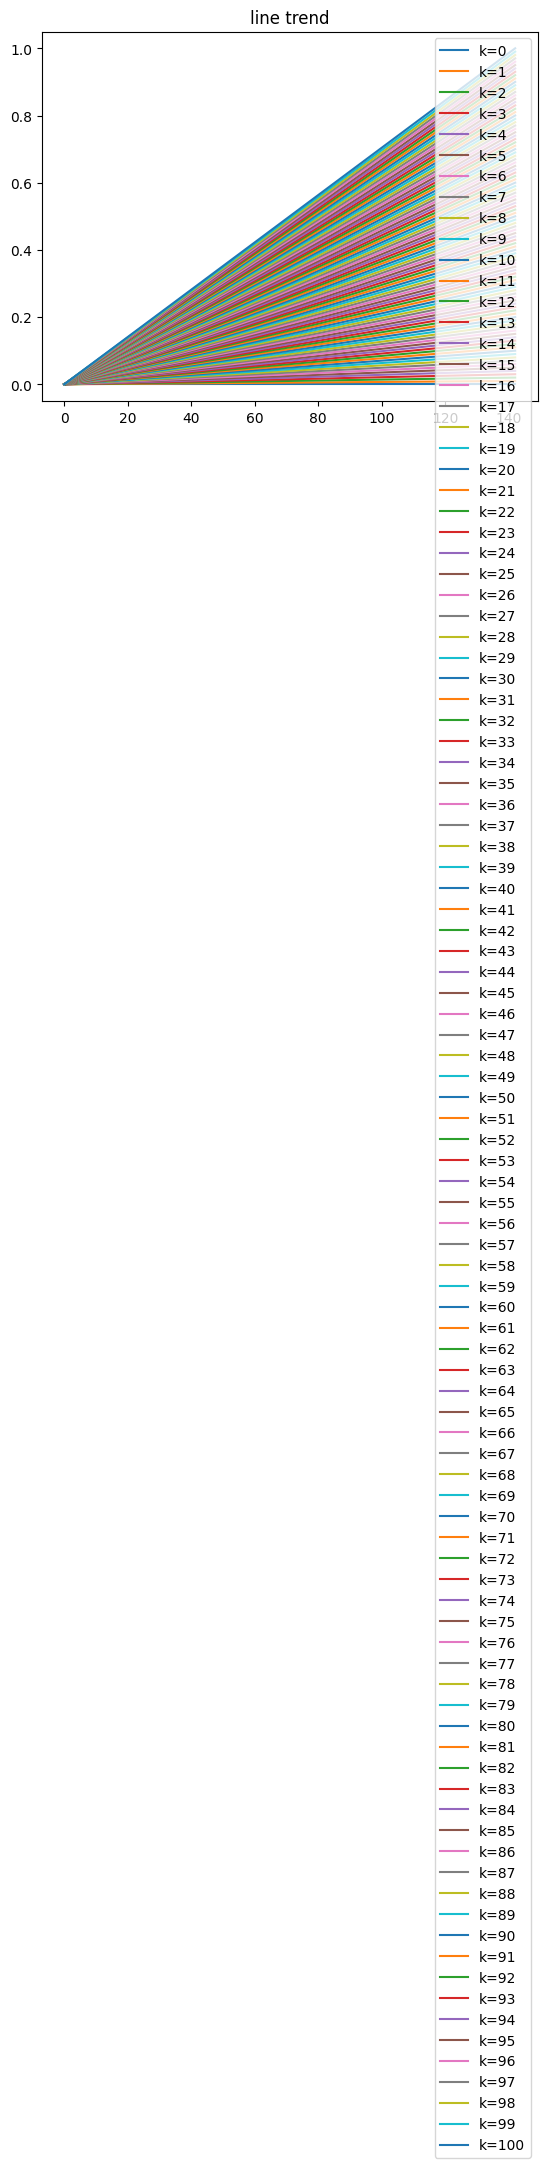

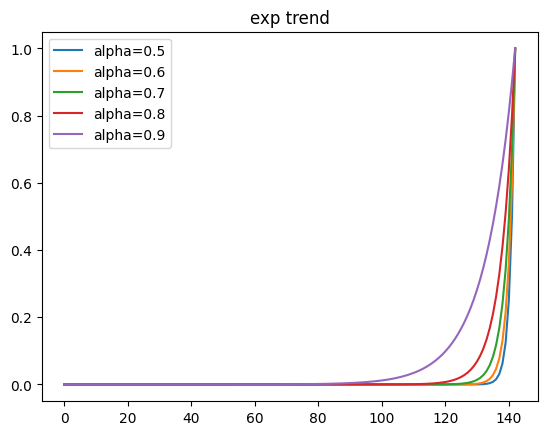

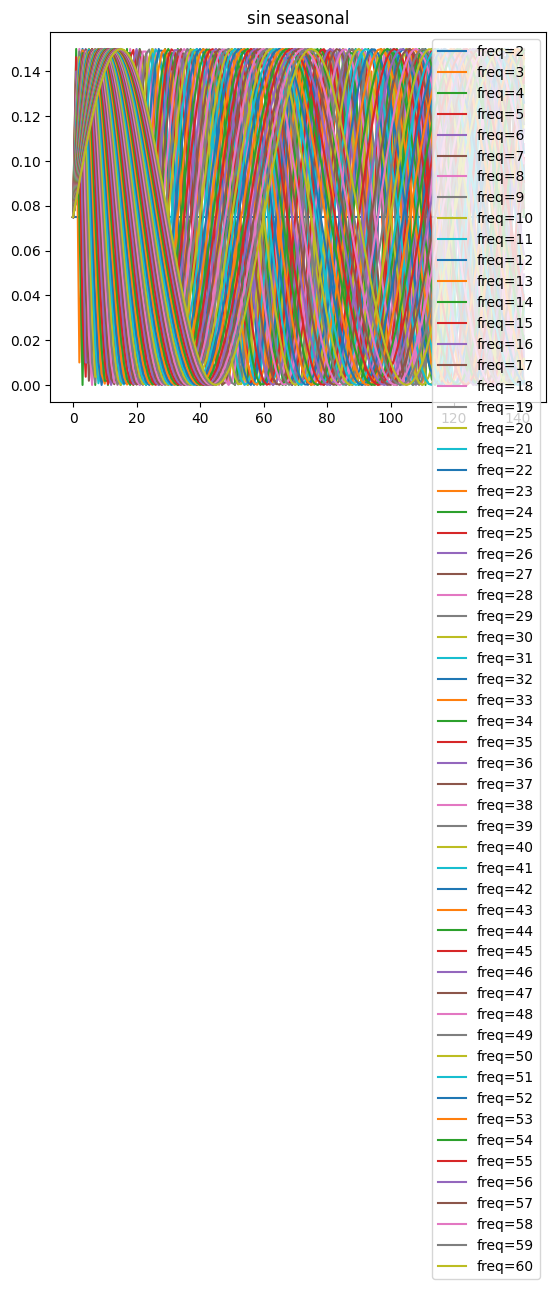

In [ ]:
t = np.arange(df.shape[0])
coefficient = np.arange(0, 101)
alphas = np.array([.5, .6, .7, .8, .9])
frequencies = np.arange(2, 61)

gc = GenerateComponents(t)
show = Show()

line_trend = gc.gen_line_trend(coefficient)
name_line_trend = [f'k={c}' for c in coefficient]
show.one_plot(line_trend.data, name_line_trend, title=f'line trend')

exp_trend = gc.gen_exp_trend(alphas)
name_exp_trend = [f'alpha={a}' for a in alphas]
show.one_plot(exp_trend.data, name_exp_trend, title=f'exp trend')


seasonal = gc.gen_seasonal(frequencies, .15)
name_seasonal = [f'freq={f}' for f in frequencies]
show.one_plot(seasonal.data, name_seasonal, title='sin seasonal')

name = name_line_trend + name_exp_trend + name_seasonal

# name = []
# seasonals = None
# for i, coef in enumerate(coefs):
#   seasonal = gc.gen_seasonal(frequencies, coef)
#   name_s = [f'c={coef}, freq={f}' for f in frequencies]
#   if not i:
#     seasonals = seasonal
#   else:
#     seasonals = seasonals + seasonal
#   name += name_s
#   show.one_plot(seasonal.data, name_s, )

## analys

In [2]:
# gd = GenerateData(df.y, line_trend.data) + GenerateData(df.y, exp_trend.data) + GenerateData(df.y, seasonal.data)

base_path = '/content/drive/MyDrive/SckillFactory/ВУЗ/диплом/data/output/'
df_snaive_path = base_path + 'STL_H_SN_compare_2.csv'
df_sarima_path = base_path + 'STL_H_SARIMA_compare.csv'


In [10]:
df_sarima.iloc[101:]

name       mae       mse     p_rmse
101  alpha=0.5  0.112099  0.063521  25.203299
102  alpha=0.6  0.134023  0.074902  27.368239
103  alpha=0.7  0.169304  0.094476  30.736992
104  alpha=0.8  0.238287  0.133496  36.537044
105  alpha=0.9  0.395407  0.229416  47.897440
..         ...       ...       ...        ...
160    freq=56  0.045957  0.002697   5.192950
161    freq=57  0.047839  0.003112   5.578947
162    freq=58  0.047869  0.003274   5.722245
163    freq=59  0.051139  0.003607   6.005750
164    freq=60  0.053463  0.003880   6.229195

[64 rows x 4 columns]

In [12]:
df_sarima = pd.read_csv(df_snaive_path)
df_sarima['p_rmse'] = np.sqrt(df_sarima.mse) * 100
df_sarima.iloc[:101].p_rmse.diff().describe()

count    1.000000e+02
mean     1.467271e-14
std      1.350044e-12
min     -3.668177e-12
25%     -7.337464e-13
50%      0.000000e+00
75%      7.798207e-13
max      3.668177e-12
Name: p_rmse, dtype: float64

In [ ]:
# stl_h_sn_compare = STLHSNaiveCompare(gd, name, df_snaive_path)
# stl_h_sn_compare.compare()

All combinations 165
cimbination 1
cimbination 2
cimbination 3
cimbination 4
cimbination 5
cimbination 6
cimbination 7
cimbination 8
cimbination 9
cimbination 10
cimbination 11
cimbination 12
cimbination 13
cimbination 14
cimbination 15
cimbination 16
cimbination 17
cimbination 18
cimbination 19
cimbination 20
cimbination 21
cimbination 22
cimbination 23
cimbination 24
cimbination 25
cimbination 26
cimbination 27
cimbination 28
cimbination 29
cimbination 30
cimbination 31
cimbination 32
cimbination 33
cimbination 34
cimbination 35
cimbination 36
cimbination 37
cimbination 38
cimbination 39
cimbination 40
cimbination 41
cimbination 42
cimbination 43
cimbination 44
cimbination 45
cimbination 46
cimbination 47
cimbination 48
cimbination 49
cimbination 50
cimbination 51
cimbination 52
cimbination 53
cimbination 54
cimbination 55
cimbination 56
cimbination 57
cimbination 58
cimbination 59
cimbination 60
cimbination 61
cimbination 62
cimbination 63
cimbination 64
cimbination 65
cimbination 6

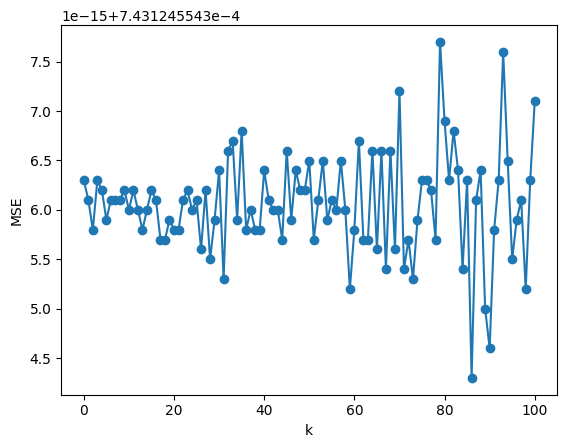

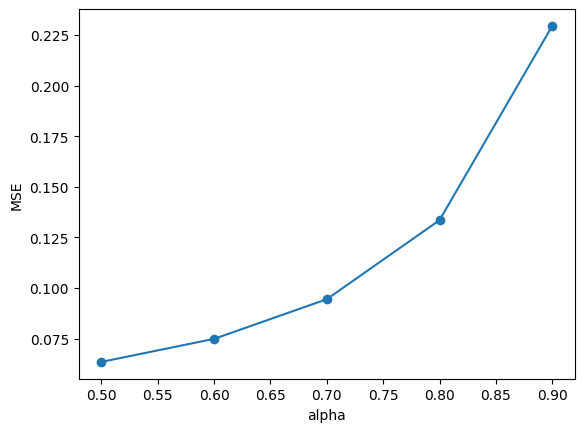

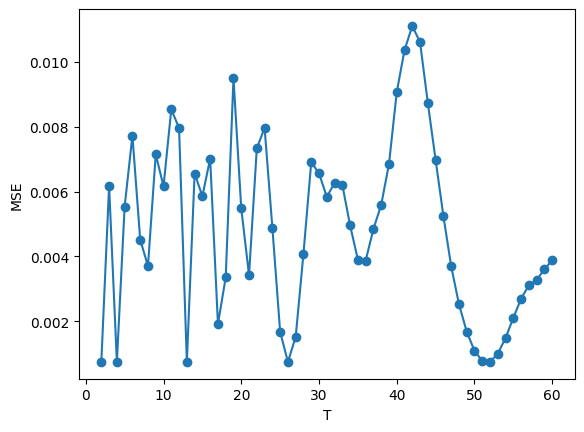

In [ ]:
df_snaive = pd.read_csv(df_snaive_path)


def plot(df_sarima, column='mae'):
  dft = df_sarima.iloc[:line_trend.data.shape[0]]
  dfa = df_sarima.iloc[line_trend.data.shape[0]:-seasonal.data.shape[0]]
  dfs = df_sarima.iloc[-seasonal.data.shape[0]:]

  plt.plot(range(dft.shape[0]), dft[column], marker='o')
  plt.ylabel(column.upper())
  plt.xlabel('k')
  plt.show()

  plt.plot([0.5, 0.6, 0.7, 0.8, 0.9], dfa[column], marker='o')
  plt.ylabel(column.upper())
  plt.xlabel('alpha')
  plt.show()

  plt.plot(range(2, dfs.shape[0] + 2), dfs[column], marker='o')
  plt.ylabel(column.upper())
  plt.xlabel('T')
  plt.show()

plot(df_snaive, 'mse')

In [ ]:
# stl_h_sarima_compare = STLHSARIMACompare(gd, name, df_sarima_path)
# stl_h_sarima_compare.compare()

All combinations 165
cimbination 1
cimbination 2
cimbination 3
cimbination 4
cimbination 5
cimbination 6
cimbination 7
cimbination 8
cimbination 9
cimbination 10
cimbination 11
cimbination 12
cimbination 13
cimbination 14
cimbination 15
cimbination 16
cimbination 17
cimbination 18
cimbination 19
cimbination 20
cimbination 21
cimbination 22
cimbination 23
cimbination 24
cimbination 25
cimbination 26
cimbination 27
cimbination 28
cimbination 29
cimbination 30
cimbination 31
cimbination 32
cimbination 33
cimbination 34
cimbination 35
cimbination 36
cimbination 37
cimbination 38
cimbination 39
cimbination 40
cimbination 41
cimbination 42
cimbination 43
cimbination 44
cimbination 45
cimbination 46
cimbination 47
cimbination 48
cimbination 49
cimbination 50
cimbination 51
cimbination 52
cimbination 53
cimbination 54
cimbination 55
cimbination 56
cimbination 57
cimbination 58
cimbination 59
cimbination 60
cimbination 61
cimbination 62
cimbination 63
cimbination 64
cimbination 65
cimbination 6

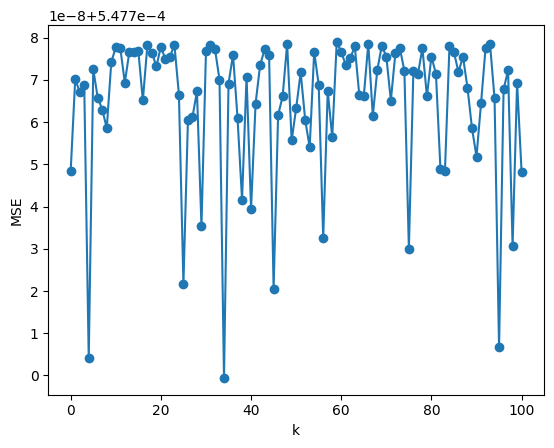

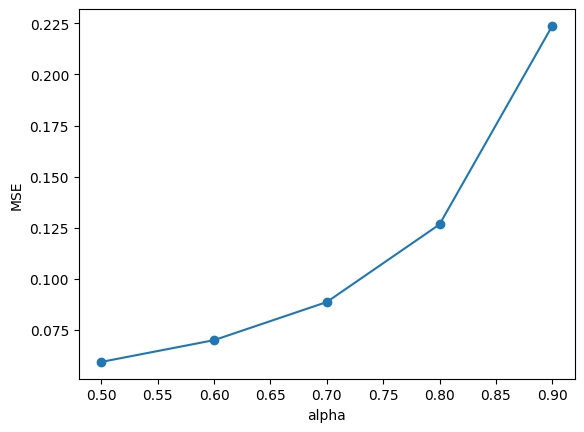

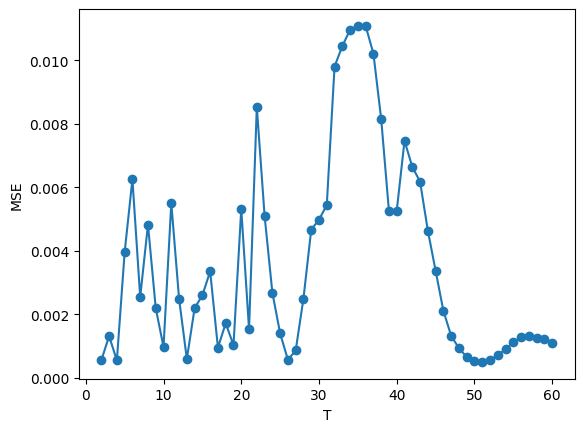

In [ ]:
df_sarima = pd.read_csv(df_sarima_path)


def plot(df_sarima, column='mae'):
  dft = df_sarima.iloc[:line_trend.data.shape[0]]
  dfa = df_sarima.iloc[line_trend.data.shape[0]:-seasonal.data.shape[0]]
  dfs = df_sarima.iloc[-seasonal.data.shape[0]:]

  plt.plot(range(dft.shape[0]), dft[column], marker='o')
  plt.ylabel(column.upper())
  plt.xlabel('k')
  plt.show()

  plt.plot([0.5, 0.6, 0.7, 0.8, 0.9], dfa[column], marker='o')
  plt.ylabel(column.upper())
  plt.xlabel('alpha')
  plt.show()

  plt.plot(range(2, dfs.shape[0] + 2), dfs[column], marker='o')
  plt.ylabel(column.upper())
  plt.xlabel('T')
  plt.show()

plot(df_sarima, 'mse')

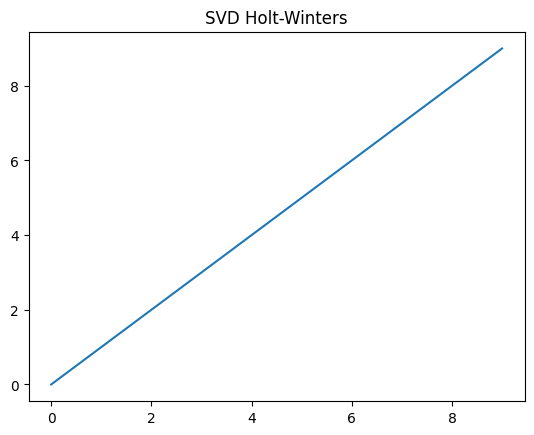

In [ ]:
plt.plot(range(10))
plt.title('SVD Holt-Winters')
plt.show()

In [ ]:
data_trend, data_exp, data_seasonal = [], [], []
data_seasonal_not_trend, data_seasonal_not_exp_trend, data_trend_not_seasonal = [], [], []
for tr in GenerateData(df.y, line_trend.data).data:
  stl = STL(tr, period=52, robust=True)
  result = stl.fit()
  data_trend.append(result.trend)
  data_seasonal_not_trend.append(result.seasonal)

for tr in GenerateData(df.y, exp_trend.data).data:
  stl = STL(tr, period=52, robust=True)
  result = stl.fit()
  data_exp.append(result.trend)
  data_seasonal_not_exp_trend.append(result.seasonal)

for tr in GenerateData(df.y, seasonal.data).data:
  stl = STL(tr, period=52, robust=True)
  result = stl.fit()
  data_seasonal.append(result.seasonal)
  data_trend_not_seasonal.append(result.trend)

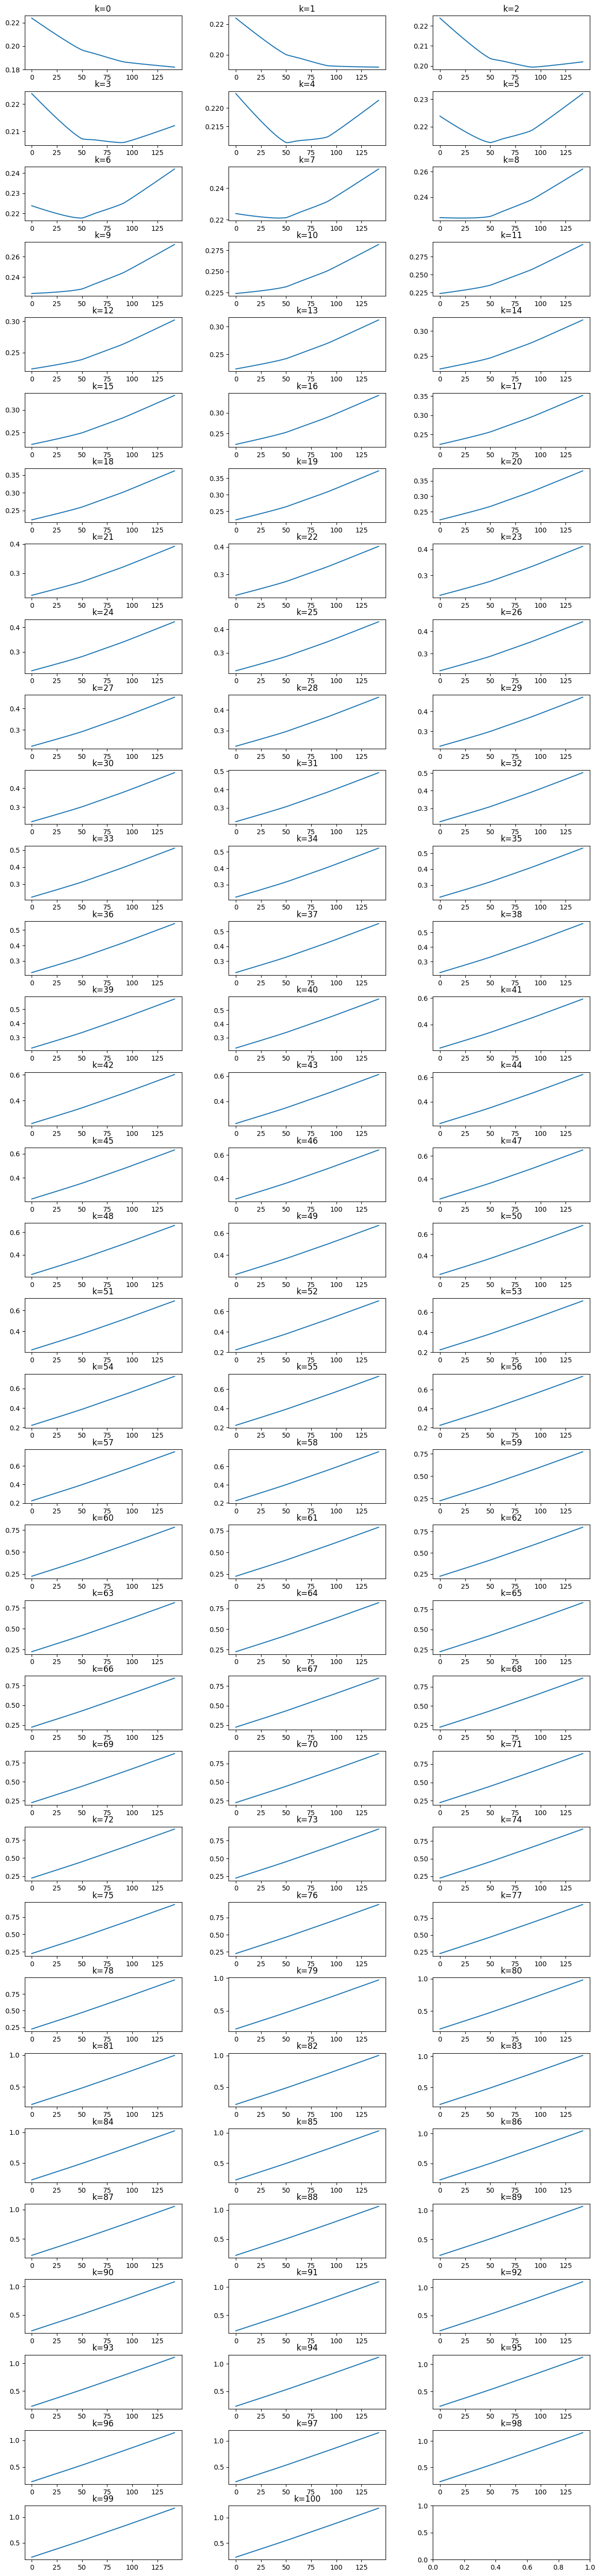

In [ ]:
# Line trend
show = Show()

max_k = len(data_trend)
show.subplot_x(np.array(data_trend)[:max_k], 3)

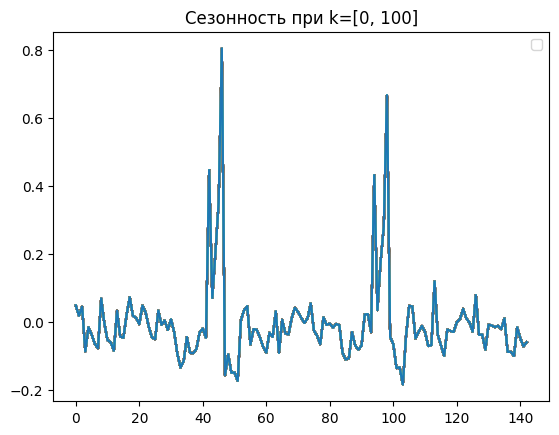

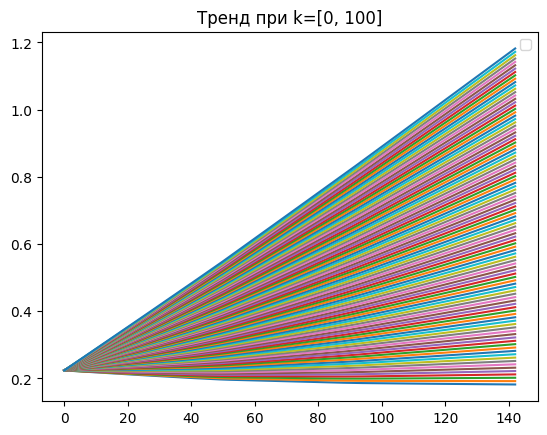

In [ ]:
show = Show()
# show.subplot_x(np.array(data_seasonal_not_trend), 3)
show.one_plot(np.array(data_seasonal_not_trend), [f'k={i}' for i in range(0, 101)],title='Сезонность при k=[0, 100]', show_labels=False)
show.one_plot(np.array(data_trend), [f'k={i}' for i in range(0, 101)],title='Тренд при k=[0, 100]', show_labels=False)

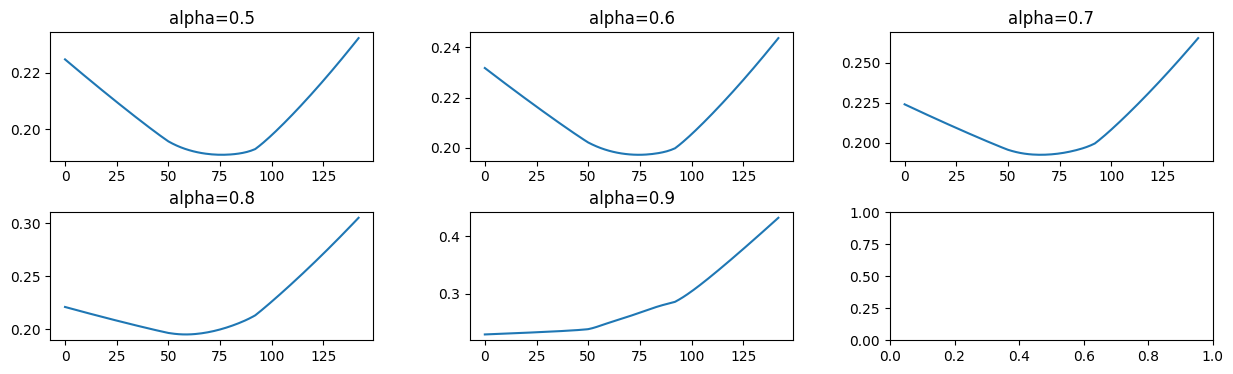

In [ ]:
# Exsponencial trend
show = Show()

max_k = len(data_exp)
show.subplot_x(np.array(data_exp)[:max_k], 3)

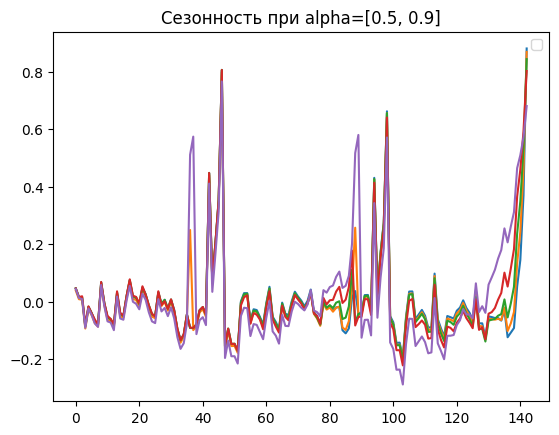

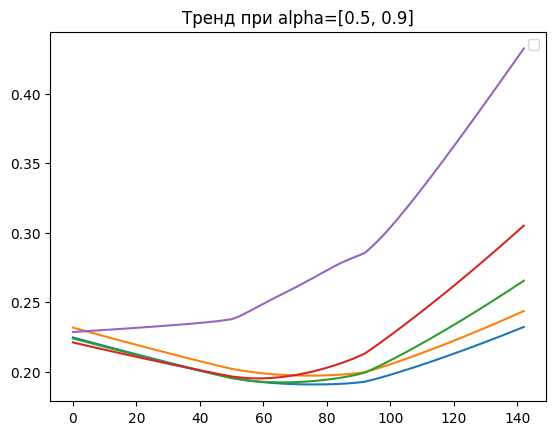

In [ ]:
show.one_plot(np.array(data_seasonal_not_exp_trend), [f'alpha={i}' for i in [0.5, 0.6, 0.7, 0.8, 0.9]],title='Сезонность при alpha=[0.5, 0.9]', show_labels=False)
show.one_plot(np.array(data_exp), [f'alpha={i}' for i in [0.5, 0.6, 0.7, 0.8, 0.9]],title='Тренд при alpha=[0.5, 0.9]', show_labels=False)

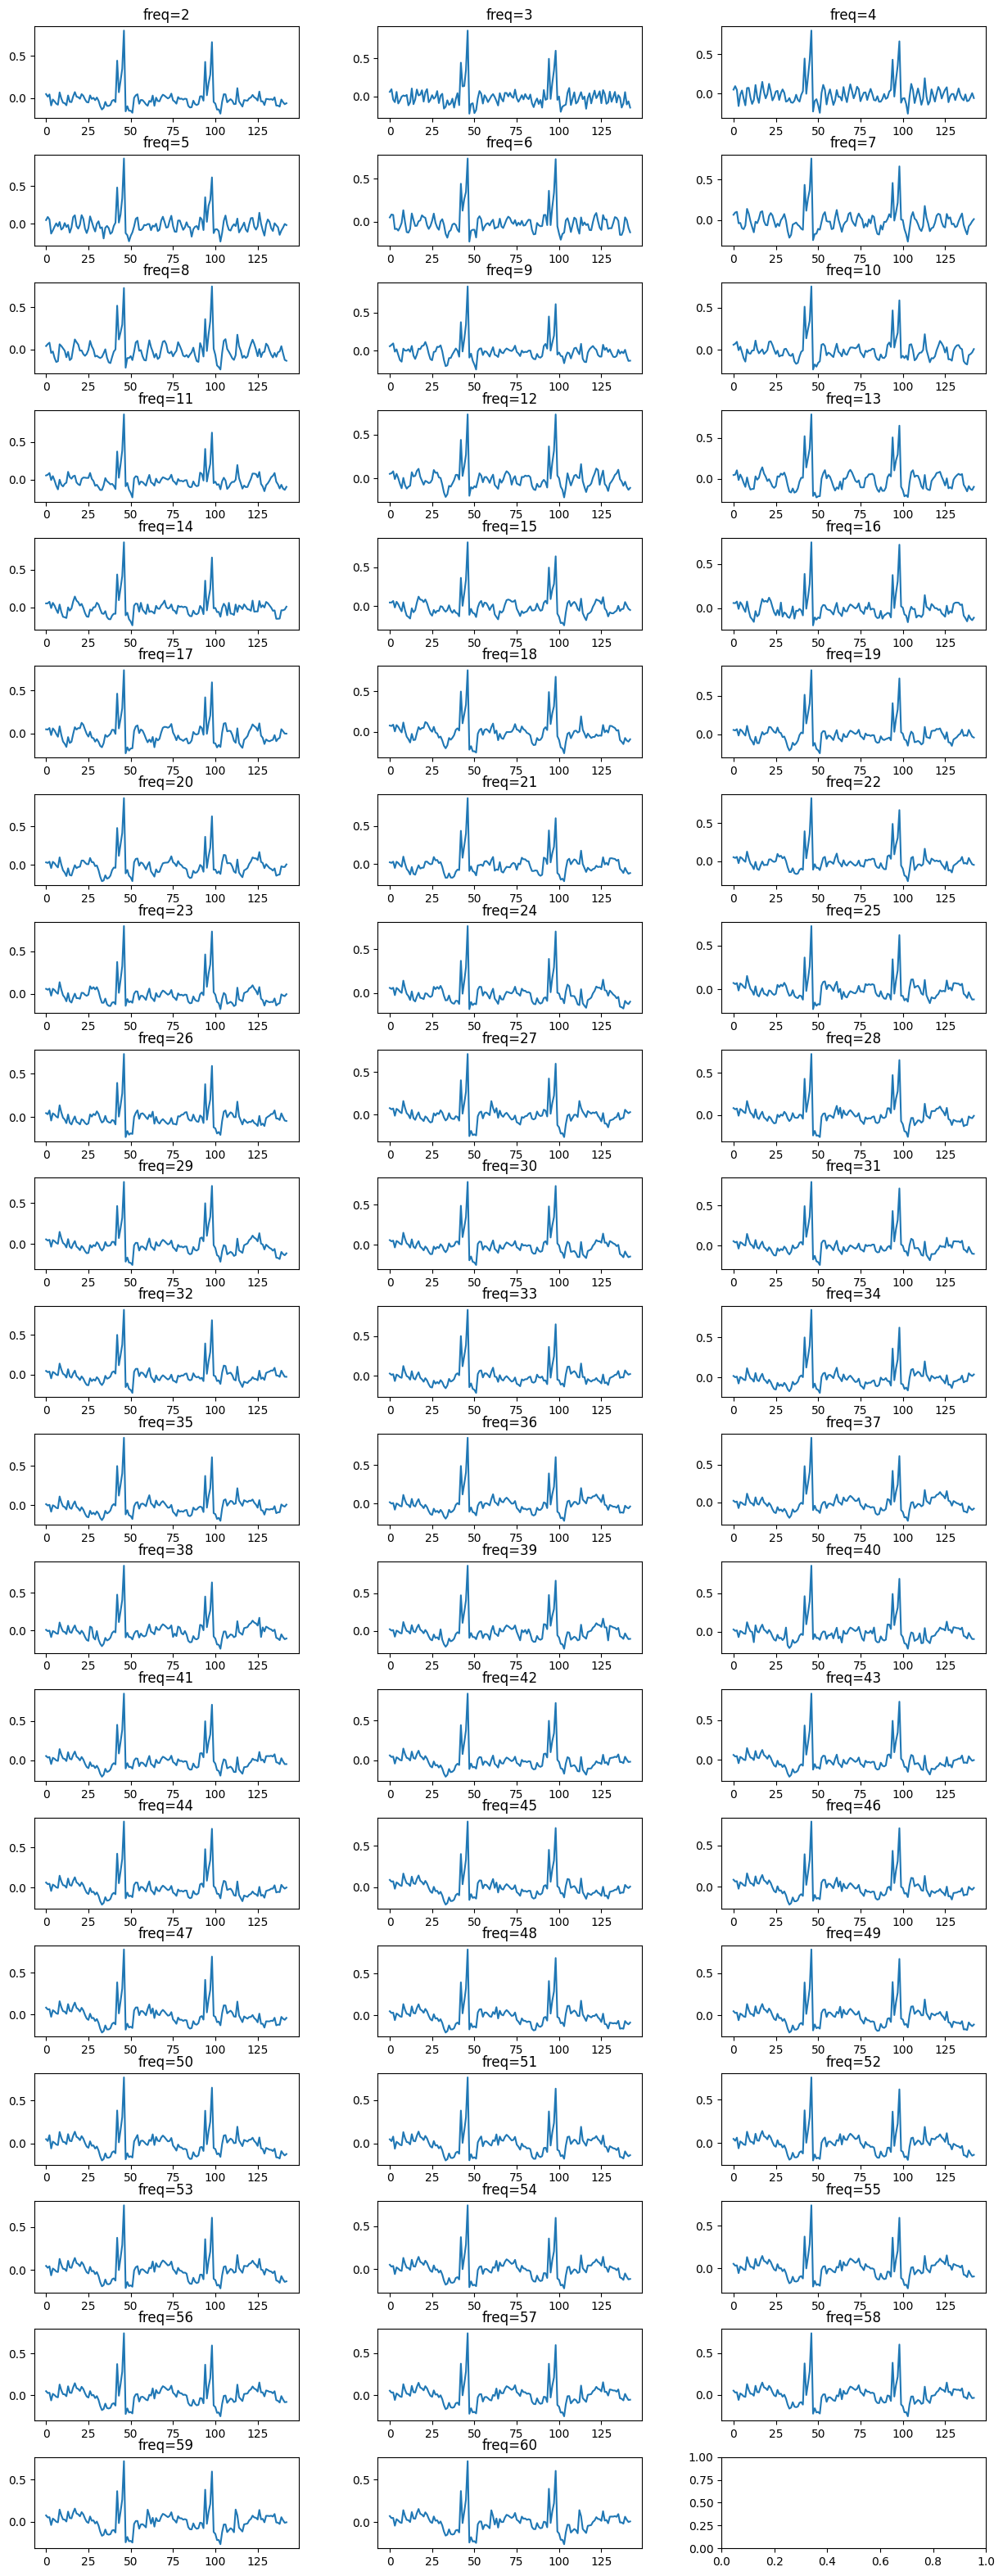

In [ ]:
# Seasonal
show = Show()

max_k = len(data_seasonal)
show.subplot_x(np.array(data_seasonal)[:max_k], 3)

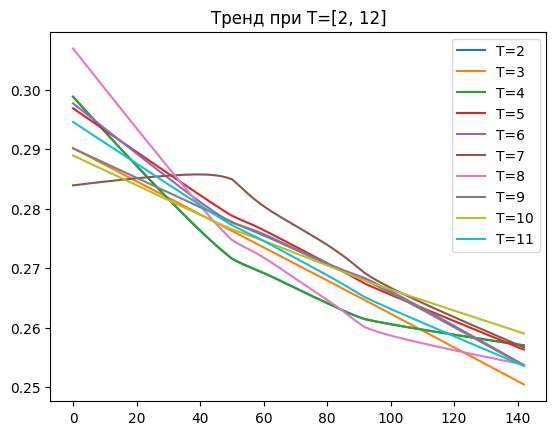

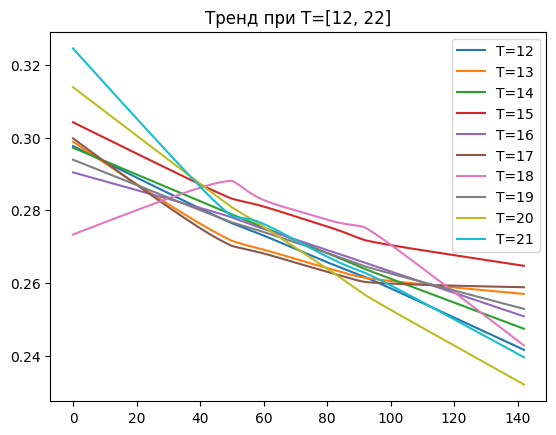

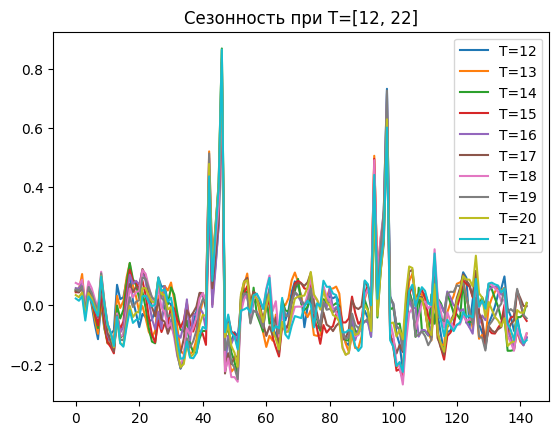

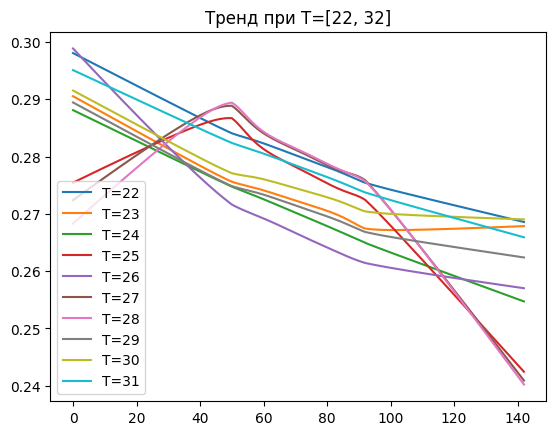

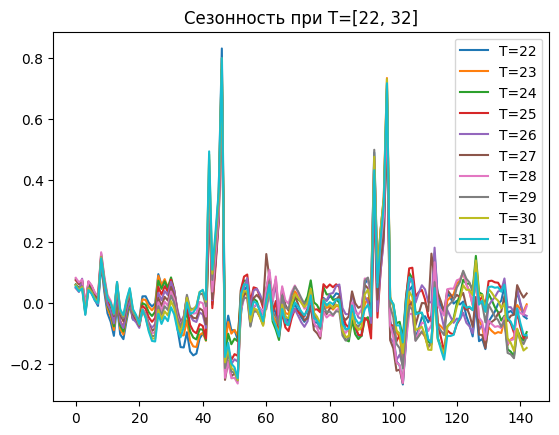

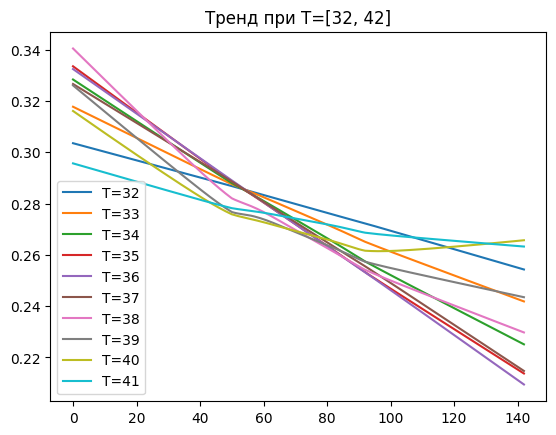

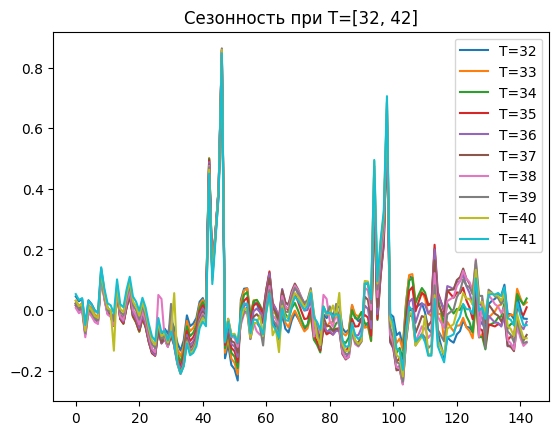

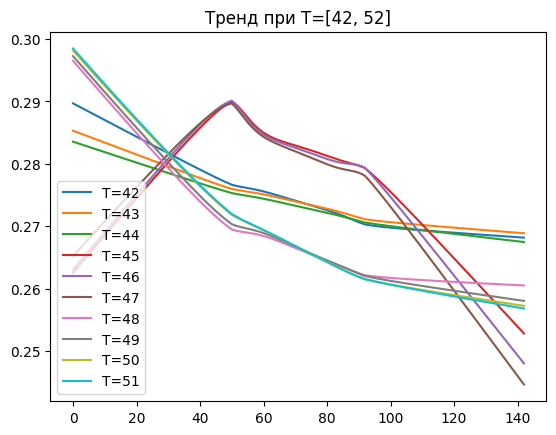

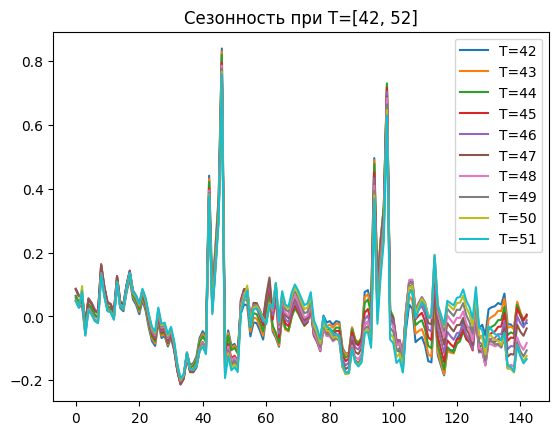

In [ ]:
show = Show()
max_t = 10

for max_t in range(10, len(data_trend_not_seasonal), 10):
  start_t = max_t - 10
  show.one_plot(np.array(data_trend_not_seasonal[start_t:max_t]), [f'T={i + 2}' for i in range(start_t, max_t)],title=f'Тренд при T=[{start_t + 2}, {max_t + 2}]', show_labels=True)
  show.one_plot(np.array(data_seasonal[start_t:max_t]), [f'T={i + 2}' for i in range(start_t, max_t)],title=f'Сезонность при T=[{start_t + 2}, {max_t + 2}]', show_labels=True)


## SVD

### **utils**

In [ ]:
def _SVD(ts, L):
  '''
  Создает матрицу траекторий и
    производит сингулярное разложение
  '''
  # Шаг 1: Построение траекторной матрицы
  K = len(ts) - L + 1
  X = np.array([ts[i:i+L] for i in range(K)]).T

  # Шаг 2: SVD
  U, S, Vt = svd(X)

  return (U, S, Vt, X, K)

def _restoration_ts(X_clean, ts_len, L, K):
  '''
  Возвращает восстановленный ряд по матрице траекторий X_clean
  '''
  ts_clean = np.zeros(ts_len)
  for i in range(ts_len):
      ts_clean[i] = np.mean([X_clean[i - j, j] for j in range(max(0, i - L + 1), min(i + 1, K))])
  return ts_clean

def _get_ts_clean(ts, L, include):
  '''
  Вычисляет отчищенную матрицу траекторий
    по сингулярным числам из include

  Возвращает востановленный ряд по
    отчищенной матрице
  '''
  U, S, Vt, X, K = _SVD(ts, L)
  X_clean = U[:, include] @ np.diag(S[include]) @ Vt[include, :]
  return _restoration_ts(X_clean, len(ts), L, K)

### **model**

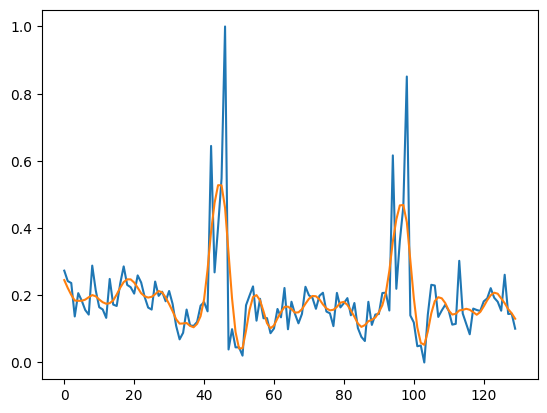

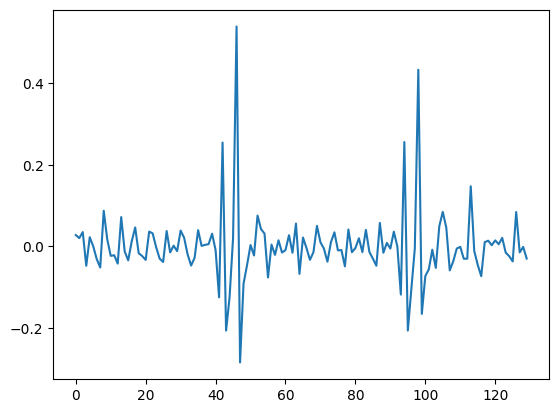

In [ ]:
trend = _get_ts_clean(Y_train_df.y.values, 20, [0, 1, 2, 3, 4])

plt.plot(Y_train_df.y.values, label='True')
plt.plot(trend, label='trend')
plt.show()

plt.plot(Y_train_df.y.values - trend)
plt.show()